Epoch 1
-------------------------------
loss: 2.308615  [   64/60000]
loss: 0.788222  [ 6464/60000]
loss: 0.306679  [12864/60000]
loss: 0.472339  [19264/60000]
loss: 0.179771  [25664/60000]
loss: 0.196626  [32064/60000]
loss: 0.105372  [38464/60000]
loss: 0.198649  [44864/60000]
loss: 0.267149  [51264/60000]
loss: 0.158393  [57664/60000]
Accuracy: 95.4%, Avg loss: 0.152561 

Epoch 2
-------------------------------
loss: 0.143228  [   64/60000]
loss: 0.277791  [ 6464/60000]
loss: 0.124670  [12864/60000]
loss: 0.084801  [19264/60000]
loss: 0.093479  [25664/60000]
loss: 0.188515  [32064/60000]
loss: 0.070121  [38464/60000]
loss: 0.014149  [44864/60000]
loss: 0.163494  [51264/60000]
loss: 0.281264  [57664/60000]
Accuracy: 96.7%, Avg loss: 0.109027 

Epoch 3
-------------------------------
loss: 0.083679  [   64/60000]
loss: 0.023499  [ 6464/60000]
loss: 0.048801  [12864/60000]
loss: 0.074569  [19264/60000]
loss: 0.027175  [25664/60000]
loss: 0.100871  [32064/60000]
loss: 0.127784  [38464/6

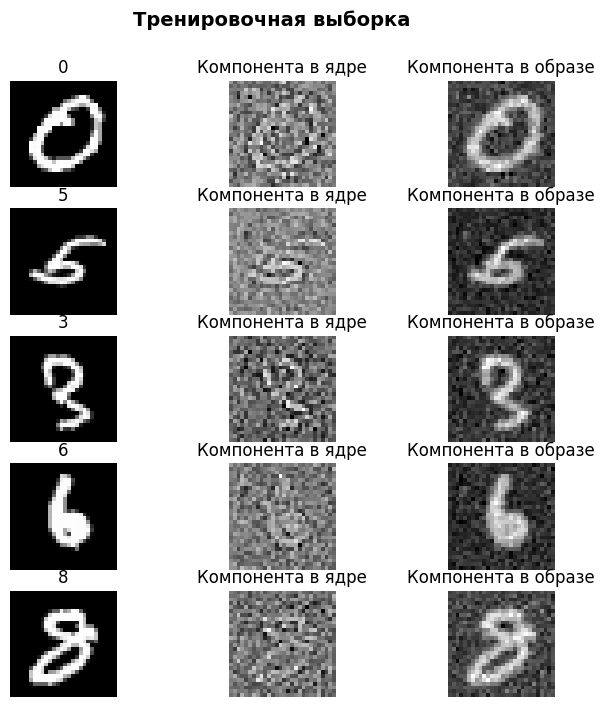

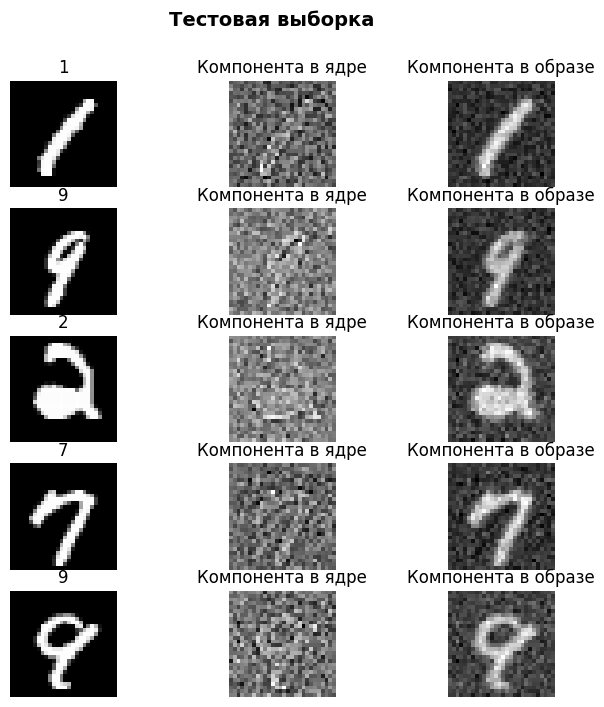

In [28]:
import os
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

device = "cpu"

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.network = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.network(x)
        return logits


model = NeuralNetwork().to(device)


def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

# Обучение
learning_rate = 1e-3
batch_size = 64
epochs = 10
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)


# Сингулярное разложение матрицы весов первого слоя
first_layer_weights = model.network[0].weight
W = first_layer_weights.view(first_layer_weights.shape[0], -1)

U, S, Vh = torch.linalg.svd(W, full_matrices=True)


epsilon = 1e-5
rank = (S > epsilon).sum().item()
null_dim = W.shape[1] - rank


def add_plot(P, data, data_type):
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 5
    for i in range(1, rows + 1):
        sample_idx = torch.randint(len(data), size=(1,)).item()
        img, label = data[sample_idx]

        #Обычное изображение
        figure.add_subplot(rows, cols, 1 + (i - 1) * (cols))
        plt.title(label)
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")

        #Компонента в ядре
        img_in_ker = P @ img.flatten()
        img_in_ker = img_in_ker.view(28, 28)
        figure.add_subplot(rows, cols, 2 + (i - 1) * (cols))
        plt.title('Компонента в ядре')
        plt.axis("off")
        plt.imshow(img_in_ker.detach().numpy().squeeze(), cmap="gray")

        #Компонента в образе
        img_in_range = (torch.eye(P.shape[0]) - P) @ img.flatten()
        img_in_range = img_in_range.view(28, 28)
        figure.add_subplot(rows, cols, 3 + (i - 1) * (cols))
        plt.title('Компонента в образе')
        plt.axis("off")
        plt.imshow(img_in_range.detach().numpy().squeeze(), cmap="gray")
    figure.text(0.5, 0.95, data_type, ha='center', fontsize=14, fontweight='bold')


if null_dim > 0:
    null_space_basis = Vh[rank:, :]
    P = null_space_basis.T @ null_space_basis
    add_plot(P, training_data, "Тренировочная выборка")
    add_plot(P, test_data, "Тестовая выборка")
    plt.show()
else:
    print("Ядро тривиально")
